# SingleDop Demo

<b>Author</b>  
Timothy Lang, NASA MSFC  
timothy.j.lang@nasa.gov

<b>Overview</b>  
SingleDop is a software module, written in the Python programming language, that will retrieve two-dimensional low-level winds from either real or simulated Doppler weather radar data. The retrieval algorithm is based on the following reference:

Xu et al., 2006: Background error covariance functions for vector wind analyses
using Doppler-radar radial-velocity observations. <i>Q. J. R. Meteorol. Soc.</i>, <b>132</b>,
2887-2904.

You should read that reference so that you understand what SingleDop does and what it is for.

SingleDop works in Python 2.7 and Python 3.4. Other Python versions are untested. The module requires the following to be installed:

- [Py-ART](https://github.com/ARM-DOE/pyart)
- [PyTDA](https://github.com/nasa/PyTDA)
- [xray/xarray](https://pypi.python.org/pypi/xarray/) (optional)
- several standard libraries like `numpy`, `scipy`, etc.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import glob
import pyart
import singledop
%matplotlib inline

The core analysis class of `singledop` is `SingleDoppler2D`. By instantiating this class with various information, you can retrieve a gridded 2D analysis object for low-level winds.

### Simulated WSW Winds
Let's get started with some simulated data. We presume a strong WSW flow field (U = 20 and V = 1 m/s). The decorrelation length scale, L, is set to 60 km. Gaussian noise in the simulated radar system sampling these winds is enabled. Additionally, we assume that the radar is only performing 180-deg PPI sectors, and data are masked within 10 km. We accept the SingleDop default that the analysis will only extend out to +/- 60 km from the radar and the resolution of the analysis will be 1 km.  

In [2]:
sd_test = singledop.SingleDoppler2D(range_limits=[10, 100], azimuth_limits=[180, 360], 
                                    L=60.0, U=20.0, V=1.0, noise=True)

8100 total observations (M)


The above should take a minute. In our case SingleDop determined that there were 8100 total observations, meaning an 8100x8100 linear matrix system that needed to be solved. Now we can display the results. SingleDop has a number of available options for displaying the data. The main class to help with this is `AnalysisDisplay`. Let's start with a vector plot.

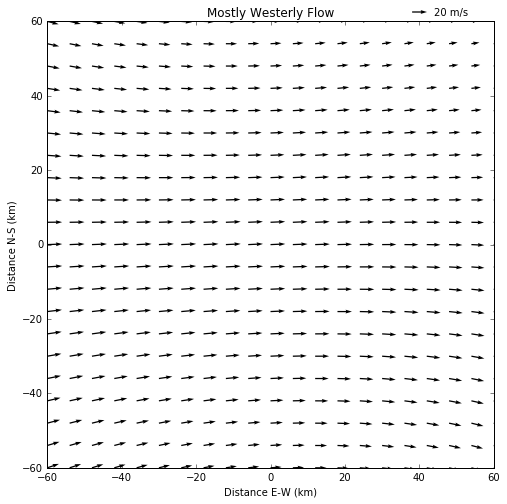

In [3]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
display = singledop.AnalysisDisplay(sd_test)
display.plot_velocity_vectors(title='Mostly Westerly Flow', thin=6, scale=600, legend=20)

The `thin` keyword is the factor by which we reduce the number of displayed vectors in order to avoid a cluttered plot. The `scale` keyword changes the base length of the vectors relative to the legend keyword value. Trial and error is your best course to figure out what combination of the above suits your needs.

We can also do contour or mesh (or both) plots for the analyzed radial and tangential velocities. You can combine these plots manually ...

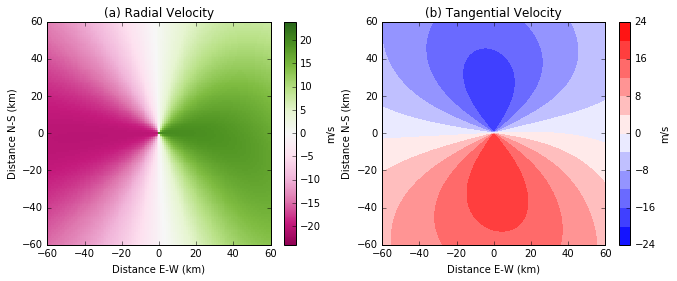

In [4]:
fig = plt.figure(figsize=(11,4))
ax1 = fig.add_subplot(121)
display.plot_velocity_contours('vr', cmap='PiYG', 
                               title='(a) Radial Velocity', mesh_flag=True)
ax2 = fig.add_subplot(122)
display.plot_velocity_contours('vt', title='(b) Tangential Velocity')

... or automatically:

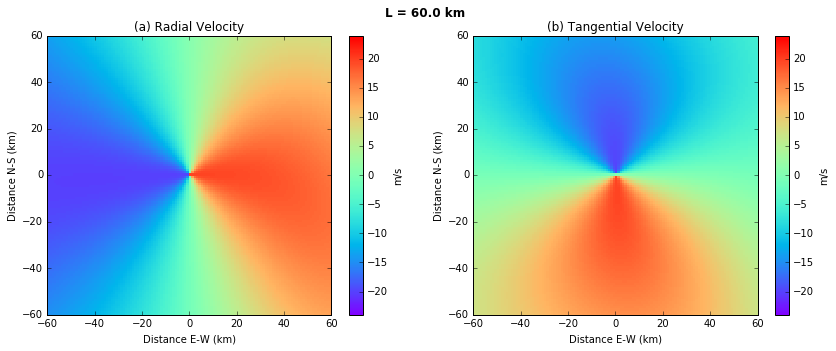

In [5]:
display.plot_radial_tangential_contours(mesh_flag=True, cmap='rainbow')

### Saving to file - pickle method

The `pickle` module is a standard python library that dumps data to a binary file, and and subsequently read that file. This provides a simple way to save our analyses for later.

In [6]:
save = singledop.SaveFile(SingleDoppler2D=sd_test, filename='data.dat')

Initializing singledop.SaveFile object
Writing to ./data.dat


Now read the file back and make sure it worked by plotting the data. You use the same `SaveFile` class for this. If its first argument is a filename, it will attempt to read that.

Attempting to read from ./data.dat


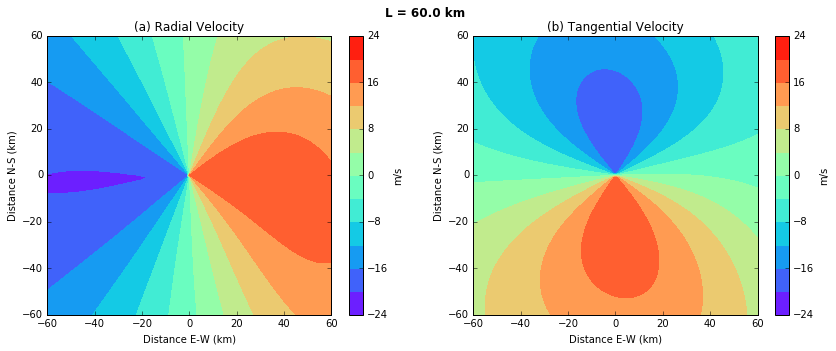

In [7]:
sd = singledop.SaveFile('data.dat')
display = singledop.AnalysisDisplay(sd)
display.plot_radial_tangential_contours(mesh_flag=False, cmap='rainbow')

In this analysis, note how the western sector is different than the eastern sector, despite the uniform wind field. This is the result of our masking of the simulated radar data using the `azimuth_limits` and `range_limits` keywords in the original `SingleDoppler2D` call.

### More Complex Wind Fields

OK, uniform wind fields are kind of boring. What if we had a frontal feature?

In [8]:
gs = 121
xgrid = np.arange(gs) - 60.0 
ygrid = np.arange(gs) - 60.0
x, y = np.meshgrid(xgrid, ygrid)
cond = y > 0.75 * x + 30
Uin = 0.0 + np.zeros((gs, gs), dtype='float')
Vin = 20.0 + np.zeros((gs, gs), dtype='float')
Uin[cond] = 15.0
Vin[cond] = -15.0

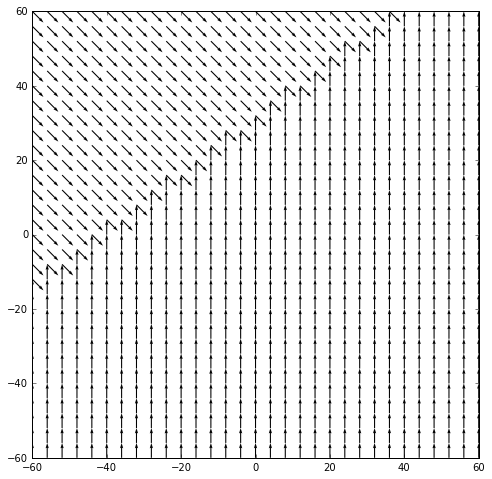

In [9]:
fig = plt.figure(figsize=(8, 8))
cond = np.logical_and(x % 4 == 0, y % 4 == 0)
ax = fig.add_subplot(111)
ax.quiver(x[cond], y[cond], Uin[cond], Vin[cond], scale=600)

`SingleDoppler2D` also can take arrays for U and V, so let's do that but now assume the radar is not masked at all (i.e., full 360-deg surveillance). We alter `L` and a few other parameters too.

In [10]:
sd_test2 = singledop.SingleDoppler2D(range_limits=[0, 90], azimuth_limits=[0, 360], 
                                     L=30.0, xgrid=np.arange(gs)-60.0, noise=True,
                                     ygrid=np.arange(gs)-60.0, U=Uin, V=Vin)

14641 total observations (M)


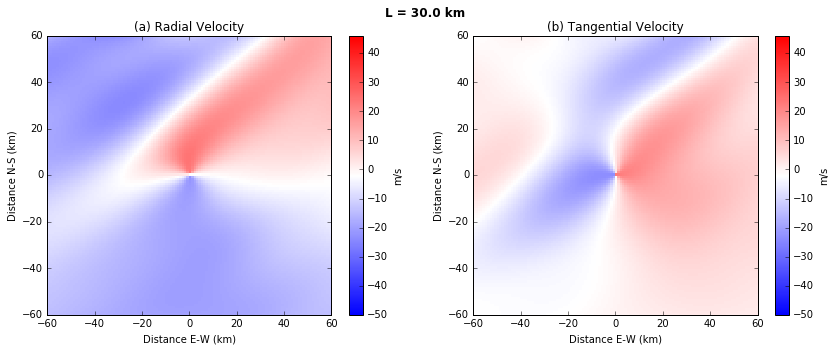

In [11]:
display = singledop.AnalysisDisplay(sd_test2)
display.plot_radial_tangential_contours(levels=-50.0+4.0*np.arange(25), mesh_flag=True)

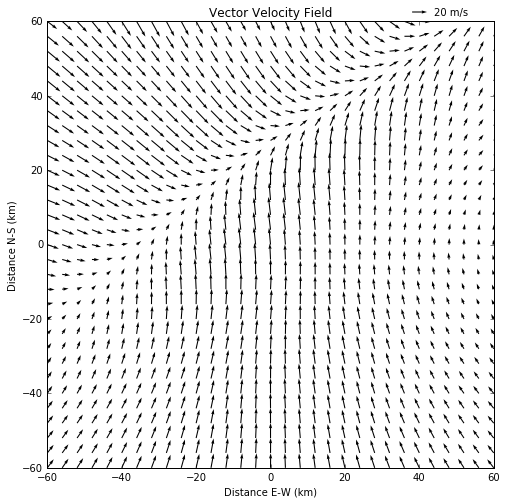

In [12]:
fig = plt.figure(figsize=(8,8))
display.plot_velocity_vectors(legend=20)

The analysis is not perfect, but the result is consistent with Xu <i>et al.</i> (2006) Figure 4, from which this example from adapted. The analysis successfully represents the presence of the 2D front, despite the use of a single simulated radar. So the module is working as intended.

### Real Radar Data

SingleDop works with Py-ART to ingest and analyze real radar data. Our example is an interesting volume from the NASA TOGA radar, taken from the DYNAMO field campaign.

In [2]:
fdir = '/Users/tjlang/Documents/OVWST/SingleDop/TestData/'
files = sorted(glob.glob(fdir+'*nc'))
iii = 1
print(os.path.basename(files[iii]))
radar = pyart.io.read(files[iii])

cfrad.20111125_043019.000_to_20111125_043754.000_toga_v0_SUR.nc


You just need to know the velocity and reflectivity field names (in our case, VE and AZ, respectively), and then send `SingleDoppler2D` the Py-ART `radar` object, to successfully run the analysis and display the results. This can take a few minutes to run, depending on your system.

In [3]:
sd_test = singledop.SingleDoppler2D(L=30.0, radar=radar, range_limits=[0, 100],
                                    sweep_number=0, name_vr='VE',
                                    thin_factor=[4, 12])

5031 total observations (M)


The use of real radar data opens up the `AnalysisDisplay.four_panel_plot()` method, which provides a nice summary of the observed and analyzed winds.

//anaconda/lib/python2.7/site-packages/pyart/graph/radardisplay.py:111: UserWarning: RadarDisplay does not correct for moving platforms
  warnings.warn('RadarDisplay does not correct for moving platforms')


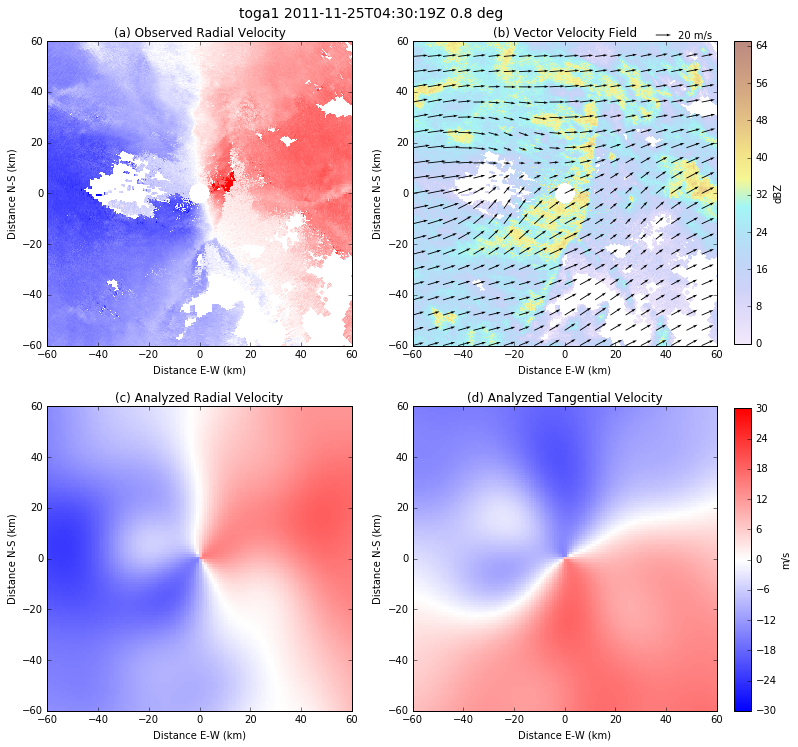

In [4]:
display = singledop.AnalysisDisplay(sd_test)
display.four_panel_plot(scale=400, legend=20, return_flag=False, thin=6,
                        levels=-30.0+2.0*np.arange(31), name_vr='VE', name_dz='AZ')

You can also filter retrieved data that is far from actual observations. To do this simply set `filter_data=True`. You may also adjust the distance from observations for which retrievals are filtered. Simply set the `filter_distance` keyword to the minimum distance (km) you desire to start filtering. Default is `L / 2`. 

In [5]:
sd_test = singledop.SingleDoppler2D(L=30.0, radar=radar, range_limits=[0, 100],
                                    sweep_number=0, name_vr='VE',
                                    thin_factor=[4, 12], filter_data=True,
                                    filter_distance=5)

5031 total observations (M)


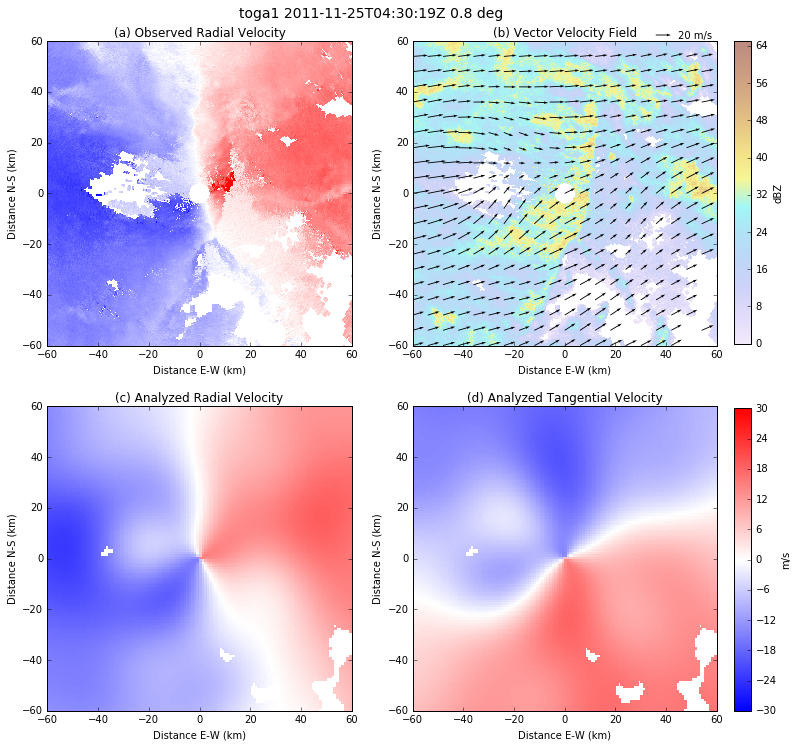

In [6]:
display = singledop.AnalysisDisplay(sd_test)
display.four_panel_plot(scale=400, legend=20, return_flag=False, thin=6,
                        levels=-30.0+2.0*np.arange(31), name_vr='VE', name_dz='AZ')

### Saving to file - netCDF method

If you have `xray` or `xarray` installed, then you can save the analyses to netCDF files rather than the less portable `pickle` files. The appropriate class to use then is `NetcdfSave`. Basic usage is similar to `SaveFile` but you need to have the `radar` object/file to fully recover all the info (e.g., for `four_panel_plot`).

In [7]:
save = singledop.NetcdfSave(sd_test, 'test.nc', radar=radar)

Now let's read it in. I need to provide the filename or radar object using the radar keyword, otherwise we can't use `four_panel_plot`.

In [8]:
save = singledop.NetcdfSave('test.nc', radar=files[iii])

Let's do a couple different plots to show this all worked. The first we'll save to file using the `save` keyword, which all plotting methods accept.

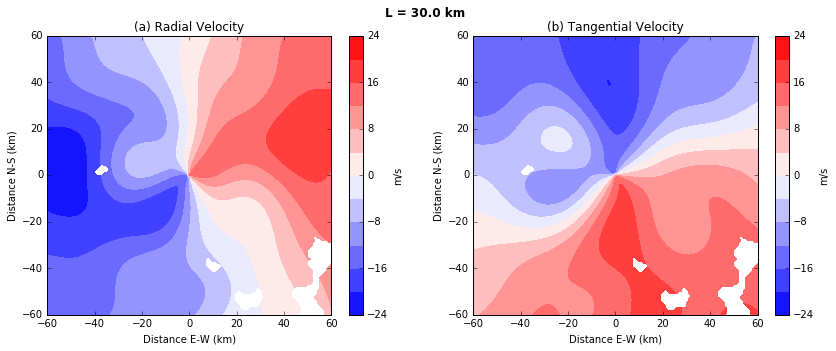

In [9]:
display = singledop.AnalysisDisplay(save)
display.plot_radial_tangential_contours(save='radial_tangential_contours.png')

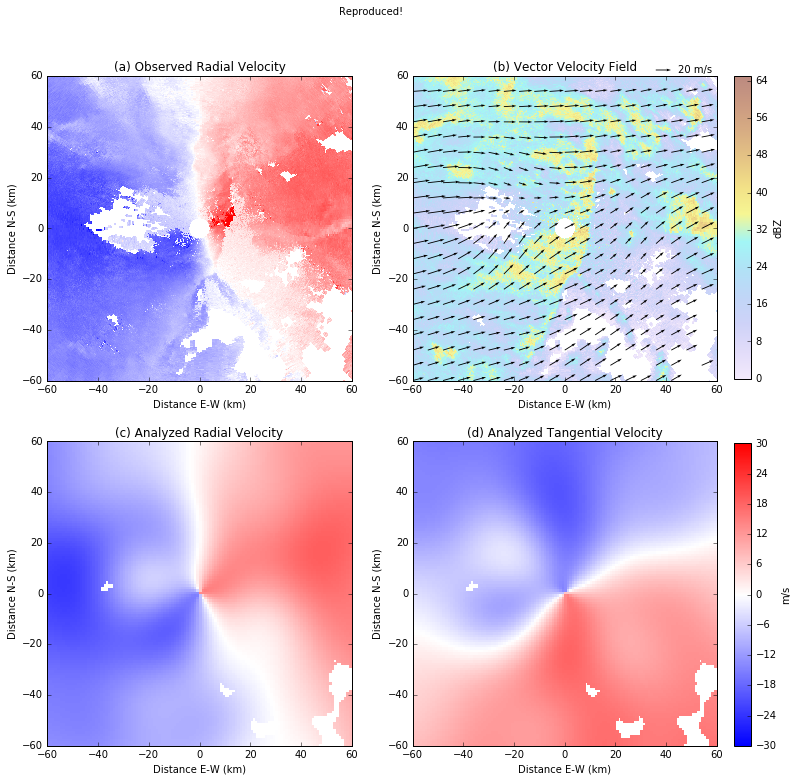

In [12]:
fig, ax1, ax2, ax3, ax4 = display.four_panel_plot(
    name_vr='VE', name_dz='AZ', return_flag=True, 
    thin=6, scale=400, legend=20, levels=-30.0+2.0*np.arange(31))
fig.suptitle('Reproduced!')

And that's about it. To finish up, here is the docstring on `SingleDoppler2D`.

In [22]:
help(singledop.SingleDoppler2D)

Help on class SingleDoppler2D in module singledop.singledop:

class SingleDoppler2D(__builtin__.object)
 |  Retrieve low-level 2D winds from either real or simulated radar
 |  observations. We work in two spaces: observation and analysis.
 |  Observation: The space where the observations are located
 |  Analysis: The space defined by the analysis grid
 |  Both are on the 2-D conical radar sweep surface
 |  
 |  Attributes
 |  ----------
 |  grid_spacing, grid_edge = Spacing, edge info to construct analysis grid
 |  sigma, sigma_obs = Standard deviation of background winds, observed winds
 |  L = Decorrelation length scale
 |  analysis_x, analysis_xf = 2D, 1D analysis grid locations along x-axis
 |  analysis_y, analysis_yf = 2D, 1D analysis grid locations along y-axis
 |  analysis_Beta = 1D non-radar-convention angle at analysis locations (0 = E)
 |  obs_xf, obs_yf = 1D arrays of Cartesian locations for observations
 |  obs_vr, obs_vrf = 2D, 1D versions of observed Doppler radial veloci